In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import random
import ssl
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request
import re
import tempfile
import pandas as pd
from tqdm import tqdm
from keras import backend as K
import sys
import csv
import os
import cv2
import math
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from google.colab import drive
import gc

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
data_root = '/content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/'
folder_root = '/content/drive/MyDrive/THESIS_GROUPS/video_classification/'

In [5]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
Videos ={}
_CACHE_DIR = tempfile.mkdtemp()
unverified_context = ssl._create_unverified_context()
# os.mkdir(folder_root)
# os.mkdir(data_root)
v = ['Punch','PushUps'] 
for classname in v:
  try:
    os.mkdir(data_root+classname)
  except:
    pass
print('The directory structure is created is created.')
def list_ucf_videos():
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    
    for i in v:
      s = "(v_"+str(i)+"[\w_]+\.avi)"
      videos = re.findall(s, index)
      Videos[i]=sorted(set(videos))
  return Videos

The directory structure is created is created.


In [6]:
unverified_context = ssl._create_unverified_context()
def fetch_ucf_video(video):
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

In [8]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"

V={}
unverified_context = ssl._create_unverified_context()
V = list_ucf_videos()
for i,value in V.items():
  _VIDEO_LIST = V[i]
  _CACHE_DIR = "/content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/" + str(i) + "/"
  for j in _VIDEO_LIST:  
    video_path = fetch_ucf_video(j)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Punch_g13_c02.avi => /content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/Punch/v_Punch_g13_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Punch_g13_c03.avi => /content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/Punch/v_Punch_g13_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Punch_g13_c04.avi => /content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/Punch/v_Punch_g13_c04.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Punch_g13_c05.avi => /content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/Punch/v_Punch_g13_c05.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Punch_g13_c06.avi => /content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/Punch/v_Punch_g13_c06.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Punch_g13_c07.avi => /content/drive/MyDrive/THESIS_GROUPS/video_classification/da

In [9]:
gc.collect()

622

In [10]:
classes = ['Punch','PushUps'] 
with open(folder_root+'dataset.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for c in classes:
    path = os.path.join(data_root, c+"/")
    for i in os.listdir(path):
      writer.writerow([classes.index(c), os.path.join(path, i)])

In [11]:
df = pd.read_csv(folder_root+'dataset.csv')
ds = df.sample(frac=1)
ds.to_csv(folder_root+'dataset.csv', index=False)

In [12]:
import numpy as np
df = pd.read_csv(folder_root+'dataset.csv', header=None)
df.columns = ["class", "path"]
df = df.astype({"class": str})
train, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

In [13]:
train.to_pickle(data_root+'train.pkl')
test.to_pickle(data_root+'test.pkl')

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

In [15]:
train_df = train
test_df = test

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 209
Total videos for testing: 53


class                                               path
171     0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
177     0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
260     0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
166     1  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
247     0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
124     1  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
18      1  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
13      0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
110     0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...
223     0  /content/drive/MyDrive/THESIS_GROUPS/video_cla...

In [16]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    #cap.set(cv2.CAP_PROP_POS_MSEC, 20000)
    frames = []
    j = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            #cv2.imwrite(data_root+"/train/"+str(j)+".jpg", img)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [17]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 2s 0us/step


In [18]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class"])
)
print(label_processor.get_vocabulary())

['0', '1']


In [19]:
gc.collect()

12016

In [20]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["path"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    for idx,path in enumerate(video_paths):
        frames = load_video(path)
        frames = frames[None, ...]

        gc.collect()
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        for i, batch in enumerate(frames):
            try:
              video_length = batch.shape[1]
              length = min(MAX_SEQ_LENGTH, video_length)
              for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
              temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
              frame_features[idx,] = temp_frame_featutes.squeeze()
              frame_masks[idx,] = temp_frame_mask.squeeze()
            except:
              pass

        gc.collect()
        print(idx, end = "")

    return (frame_features, frame_masks), labels

gc.collect()

train_data, train_labels = prepare_all_videos(train_df)
print()
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208
Frame features in train set: (209, 100, 2048)
Frame masks in train set: (209, 100)


In [21]:
gc.collect()

722

In [22]:
test_data, test_labels = prepare_all_videos(test_df)

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849505152

In [25]:
input_tensor = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#base.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

top = Dense(11, activation='softmax')(
            Dropout(0.5)(
                Dense(2048, activation='relu')(
                    Dropout(0.5)(
                        GlobalAveragePooling2D()(base.output)
                    )
                )
            )
        )

model = Model(input_tensor, top)

In [26]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.LSTM(200, return_sequences=True)(
        frame_features_input, mask=mask_input
    )

    x = keras.layers.LSTM(200, return_sequences=True)(x)

    x = keras.layers.GRU(20)(x)
    #x = keras.layers.Dropout(0.4)(x)


    x = keras.layers.Dense(2048, activation="relu")(x)
    x = keras.layers.Dense(1024, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [27]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

In [28]:
model.compile(keras.optimizers.Adam(lr=10e-5),loss = 'categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
gc.collect()

16773

In [30]:
def run_training():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    #seq_model = model
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=50,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_training()

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.5137
Epoch 00001: val_loss improved from inf to 0.61092, saving model to /tmp/video_classifier
5/5 [==============================] - 21s 2s/step - loss: 0.6035 - accuracy: 0.5137 - val_loss: 0.6109 - val_accuracy: 0.6667
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.7055
Epoch 00002: val_loss improved from 0.61092 to 0.42225, saving model to /tmp/video_classifier
5/5 [==============================] - 6s 1s/step - loss: 0.4708 - accuracy: 0.7055 - val_loss: 0.4222 - val_accuracy: 0.8571
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.9178
Epoch 00003: val_loss improved from 0.42225 to 0.26722, saving model to /tmp/video_classifier
5/5 [==============================] - 6s 1s/step - loss: 0.3587 - accuracy: 0.9178 - val_loss: 0.2672 - val_accuracy: 0.9365
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0

In [31]:
sequence_model.save(folder_root+'saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/THESIS_GROUPS/video_classification/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/THESIS_GROUPS/video_classification/saved_model/assets


In [32]:
sequence_model = keras.models.load_model(folder_root+'saved_model')

In [33]:
import imageio
from tensorflow_docs.vis import embed

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]
    v = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps']

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {str(v[class_vocab[i].astype(int)])} :{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
        
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
v = ['Punch','PushUps']

Test video path: /content/drive/MyDrive/THESIS_GROUPS/video_classification/dataset/PushUps/v_PushUps_g21_c04.avi
  HandstandWalking :1: 100.00%
  HandstandPushups :0:  0.00%



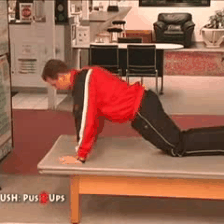

In [36]:
test_video = np.random.choice(test_df["path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])